<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:200%;
           font-family:Arial;letter-spacing:0.5px">

<p width = 20%, style="padding: 10px;
              color:white;">
Classification Metrics: ROC and AUC
              
</p>
</div>

Data Science Cohort Live NYC Feb 2023
<p>Phase 3: Topic 25</p>
<br>
<br>

<div align = "right">
<img src="Images/flatiron-school-logo.png" align = "right" width="200"/>
</div>
    
    

# Objectives
- Calculate and interpret probability estimates
- Adjust the threshold of a logistic regression model
- Visualize, calculate and interpret the AUC-ROC metric

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report # plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.preprocessing import StandardScaler

#### What is the issue?

- Related to (basically the same as) concerns around Neyman-Pearson testing

<img src = "Images/neyman_small.png" width = 300 />

- $\alpha$ is the false positive rate (reject null when null is true)
- $\beta$ is false negative rate (accept null when null is false)

- Dependent on $t_{crit}$ OR:
    - the significance level $\alpha$
    - the probability **threshold**

#### Obvious connection
- Hypothesis testing
- Probabilistic classification 

$\alpha$ and $\beta$ depends on:
- significance level
- the structure of the hypothesis test (distribution, type of test, etc.)
- the data (sample size, etc.)

Precision, recall, F-score depends on:
- threshold
- structure of model (type of model, hyperparameters)
- the data

#### Understanding model quality

Want to systematically understand:
- how changing threshold affects:
    - true positive/false positive rate
    - precision/recall 

A nice applet. Let' play with it:

http://arogozhnikov.github.io/2015/10/05/roc-curve.html

Tuning the tolerance (the significance level):
- Traces out a curve in (true positive rate, false positive rate) space.

**Reciever Operator Characteristic**

<img src = "Images/roc_curve.png" />

Reciever operator characteristic (ROC) curve:
- Name comes from early days of radar detection.
- WW2 operators detecting enemy airplanes.

<center><img src = "Images/azm_zero.jpeg" width = 500/></center>
<center> Detecting the Japanese AZM Zero Fighter </center>


#### The ROC curve in scikit-learn

In [48]:
from sklearn.metrics import roc_curve,RocCurveDisplay
#from sklearn.metrics import plot_roc_curve #depreciated


Load in the heart disease dataset.
[this UCI dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) 

In [49]:
hd_data = pd.read_csv('Data/heart.csv')
hd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [50]:
# Separate data into feature and target DataFrames
hd_X = hd_data.drop('target', axis=1)
hd_y = hd_data['target']
hd_X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [51]:
hd_y

0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: target, Length: 303, dtype: int64

In [52]:
hd_y.value_counts() # 1 = heart disease

1    165
0    138
Name: target, dtype: int64

In [53]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(hd_X, hd_y, test_size=.25,
                                                   random_state=1)
# Scale the data for modeling
hd_scaler = StandardScaler()
hd_scaler.fit(X_train)
X_train_sc = hd_scaler.transform(X_train)
X_test_sc = hd_scaler.transform(X_test)

# Train a logistic regresssion model with the train data
hd_model = LogisticRegression(random_state=42)
hd_model.fit(X_train_sc, y_train)

LogisticRegression(random_state=42)

In [54]:
y_pred = hd_model.predict(X_test_sc)
y_pred[:10]

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1])

When we run the `.predict()` method, `sklearn` gives us the predicted values for each transaction in our test set: 0 if predicting "no heart disease", 1 if predicting "heart disease"

Scikit-learn assumes a probability threshold of 0.5 on binary classification.

<center><img src = "Images/sigmoid.png" /></center>

Reminder: the logistic regression model doesn't actually generate predicted values of 0 or 1. It creates an S-shaped curve to approximate the data, estimating the _probability_ that they belong to the target class. This probability takes a value _between_ 0 and 1.

#### The underlying predicted probability of each class given data observation
- the .predict_proba() function

In [55]:
y_prob = hd_model.predict_proba(X_test_sc)
y_prob[:5]

array([[0.99583439, 0.00416561],
       [0.2234686 , 0.7765314 ],
       [0.91939062, 0.08060938],
       [0.99402865, 0.00597135],
       [0.97047813, 0.02952187]])

In [56]:
y_pred[:5]

array([0, 1, 0, 0, 0])

Get a 2D array:
- [P(class 0|x), P(class 1|x)] for each x in test set.

In principle:
- Can change threshold cutoff to assign to given class
- Track changes in metrics
    - True positive/false positive rate
    - Precision/recall

#### roc_curve(y_true, y_proba)
- first argument: test values
- second argument: probability of positive class    

- list of false positive rate (fpr)
- list of true positive rate (tpr)
- list of "thresholds" each fpr, tpr was calculated at:
    - actually values of decision function

### True Positive Rate
True Positive Rate (TPR) is the same as recall, measuring how many of the positive cases we correctly classified as positive.

**True Positive Rate (TPR)** = **Recall** = $\frac{TP}{TP + FN}$

Rate of correctly rejecting null (statistical power)


### False Positive Rate
False Positive Rate (FPR) measures how many of the negative casses we incorrectly classified as positive.

**False Positive Rate (TPR)** = $\frac{FP}{FP + TN}$

Rate of falsely rejecting null (Type I error)

Given test/validation set:
- calculate these metrics

#### roc_curve(y_true, y_proba)
- first argument: test values
- second argument: probability of positive class  

- list of false positive rate (fpr)
- list of true positive rate (tpr)
- list of thresholds each fpr, tpr was calculated at:

In [57]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])

List of thresholds:
- in order of: no positive identifications to always identify as positive

In [91]:
thresholds[1::]

array([0.99463107, 0.96460629, 0.95334992, 0.91532844, 0.88556113,
       0.84869964, 0.81609939, 0.79704685, 0.77717419, 0.76653064,
       0.76485113, 0.76416585, 0.75528847, 0.73637076, 0.72140869,
       0.64710039, 0.5891358 , 0.45628628, 0.2934572 , 0.28590514,
       0.18286934, 0.0887099 , 0.06707534, 0.05818162, 0.00210274])

In [59]:
thresh_df = pd.DataFrame({'threshold': thresholds,
                          'tpr':  tpr, 'fpr': fpr}).iloc[1::, :]
thresh_df.head()

,threshold,tpr,fpr
1,0.994631,0.024390,0.000000
2,0.964606,0.390244,0.000000
3,0.953350,0.390244,0.028571
4,0.915328,0.463415,0.028571
5,0.885561,0.463415,0.085714


Text(0, 0.5, 'True positive rate')

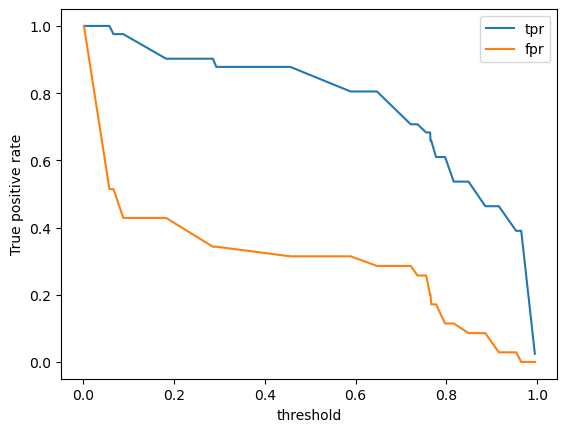

In [60]:
fig, ax = plt.subplots()
thresh_df.plot(x = 'threshold', y = 'tpr', ax = ax)
thresh_df.plot(x = 'threshold', y = 'fpr', ax = ax)
ax.set_ylabel('True positive rate')

When threshold too high:
- Both FPR and TPR close to 0
- Never detects positive class.

When threshold gets lower:
- may be increasing true positive rate
- also increasing the rate of false positives

Common to plot true positive rate vs. false positive rate:

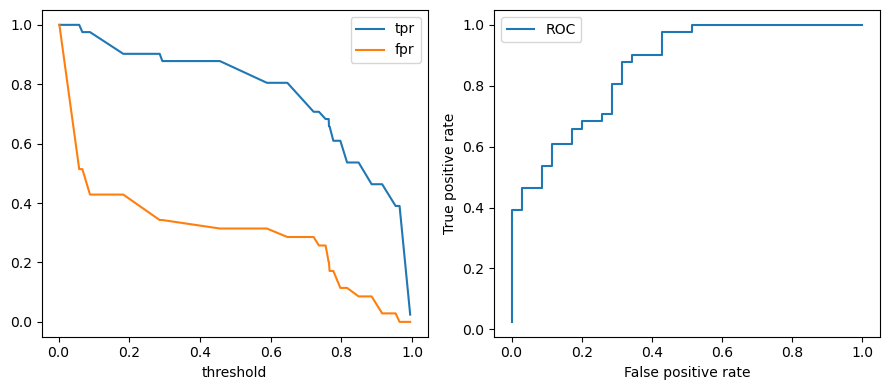

In [61]:
fig, ax = plt.subplots(1,2, figsize = (9,4))
thresh_df.plot(x = 'threshold', y = 'tpr', ax = ax[0])
thresh_df.plot(x = 'threshold', y = 'fpr', ax = ax[0])
thresh_df.plot(x = 'fpr', y = 'tpr', ax = ax[1], label = 'ROC')
ax[1].set_ylabel('True positive rate')
ax[1].set_xlabel('False positive rate')
plt.tight_layout()

#### ROC curve
- can be used to assess model quality: understand model behavior as a function of threshold
- **for a given trained model and data: get threshold sweetspot**

- for a given trained model and data: get threshold sweetspot
    - high true positive rate (good statistical power)
    - as low a false positive rate as possible (low type I error)

A useful command here: 
- directly plot ROC curve
- input our trained heart disease model and test data

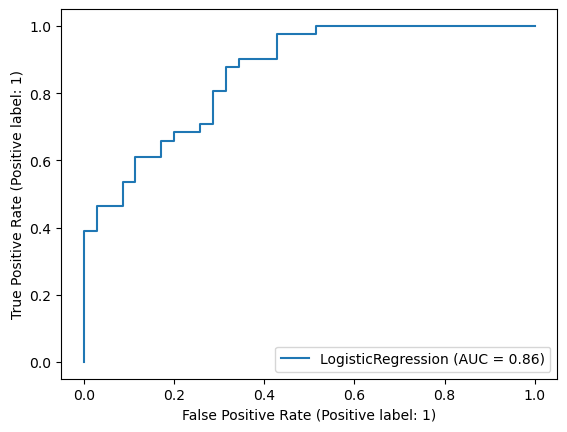

In [62]:
#plot_roc_curve(hd_model, X_test_sc, y_test);
RocCurveDisplay.from_estimator(hd_model, X_test_sc, y_test);

Lowering detection threshold:
-  If I raise significance level, lower detection threshold:
    - get more true positives
    - also get more false negatives
- Extreme case:
    - detects everything as positive class

This can be used by practicioner:
- to visually decide where to operate model threshold

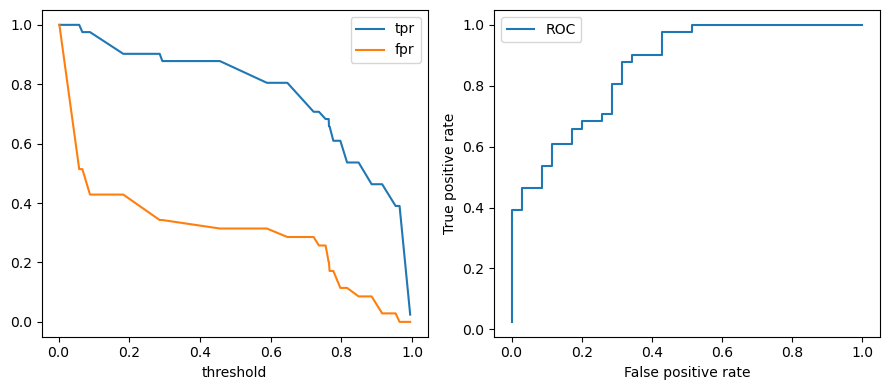

In [63]:
fig, ax = plt.subplots(1,2, figsize = (9,4))
thresh_df.plot(x = 'threshold', y = 'tpr', ax = ax[0])
thresh_df.plot(x = 'threshold', y = 'fpr', ax = ax[0])
thresh_df.plot(x = 'fpr', y = 'tpr', ax = ax[1], label = 'ROC')
ax[1].set_ylabel('True positive rate')
ax[1].set_xlabel('False positive rate')
plt.tight_layout()

Can do this visually or can use:
- calculated TPR
- calculated FPR

Choose optimal threshold that maximizes:
    
$$ J = TPR - FPR $$

Want as many true positive identifcations while minimizing false positives 

**Known as Youden's J-statistic**

In [64]:
thresh_df['J_stat'] = \
thresh_df['tpr'] - thresh_df['fpr']
thresh_df.head()

,threshold,tpr,fpr,J_stat
1,0.994631,0.024390,0.000000,0.024390
2,0.964606,0.390244,0.000000,0.390244
3,0.953350,0.390244,0.028571,0.361672
4,0.915328,0.463415,0.028571,0.434843
5,0.885561,0.463415,0.085714,0.377700


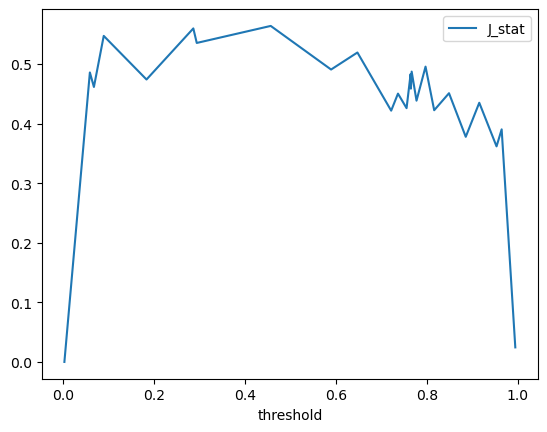

In [65]:
thresh_df.plot(x = 'threshold', y= 'J_stat');

Select threshold with highest J-statistic

In [66]:
max_selector = thresh_df.index == thresh_df['J_stat'].idxmax()

optimal_thresh = thresh_df[max_selector]
optimal_thresh

,threshold,tpr,fpr,J_stat
18,0.456286,0.878049,0.314286,0.563763


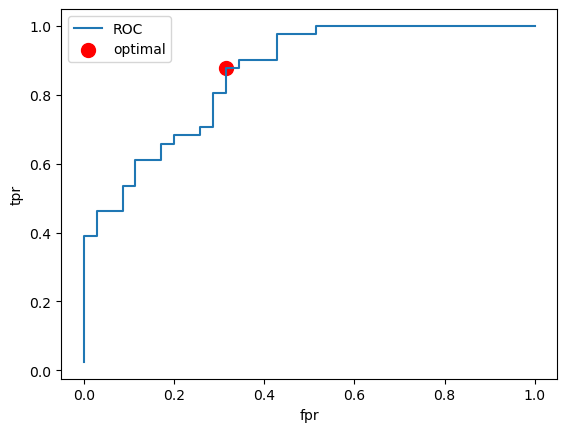

In [67]:
fig, ax = plt.subplots()
thresh_df.plot(x = 'fpr', y = 'tpr', ax = ax, label = 'ROC')
optimal_thresh.plot.scatter(x = 'fpr', y = 'tpr', c ='r', s = 100, ax = ax, label = 'optimal' )
plt.show()

Make prediction at different threshold:
- filter on threshold value other than p = 0.5

In [93]:
thresh = optimal_thresh['threshold'].values
# yes...this is the way to do it for binary class.
y_pred_with_threshold = (y_prob[:,1] >= thresh).astype(int)
y_pred_with_threshold

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1])

Original prediction at threshold p = 0.5:

In [69]:
y_pred

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1])

Takeaway so far:
- ROC can be used to visually determine best threshold to operate model at
- Yuden's statistic can help with this.

#### ROC curve
- **can be used to assess model quality: understand model behavior as a function of threshold**
- for a given trained model and data: get threshold sweetspot

What does this have to do with model quality?
- Hope is that as we change threshold we create models that typically have:
    - higher TPR vs. FPRs

Good model vs bad models

<center><img src = "Images/Roc_curves_better.png" /></center>

What affects the ROC curve?

That applet again.

http://arogozhnikov.github.io/2015/10/05/roc-curve.html

Making good models are reflected in ROC curve structure:

- Use good distribution/function for data modeling
    - Model selection (logistic regression, tree model, etc.)
    - Feature Engineering

- Decrease model variance
    - Regularization
    - Get more data

Gives our ROC curve more downward L-shaped

# Oversampling

What do you do if your model doesn't perform well due to class imbalance? One of the most effective strategies is to **oversample the minority class**. That is, I give myself more data points than I really have. I could achieve this either by [bootstrapping](https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html) or by generating some data that is fake but close to actual data. The latter is the idea behind [SMOTE](https://imbalanced-learn.org/stable/over_sampling.html).

#### ROC-AUC score

Gets the area under the ROC curve (AUC):
- Measure of model and/or data quality
- Bad model: AUC ~ 0.5 (area of triangle)
- Good model: AUC $\rightarrow$ 1

> Remember: If my test data comprises 90% positives and only 10% negatives, then a simple classifier that always predicts "positive" will be 90% accurate! And so that would be the baseline level for a classifier on that data.

<center><img src = "images/auc.png" width = 300 /></center>

<center><img src = "Images/Roc_curves_better.png" /></center>

In [70]:
from sklearn.metrics import roc_auc_score

In [71]:
# Extract the probabilitiy predictions for the "1" class (heart disease)
y_hat_hd = y_prob[:, 1]

roc_auc_score(y_test, y_hat_hd)

0.8606271777003485

Very often:
- validation tuning is done using the ROC-AUC score as metric
- tune hyperparameters to get model class with best discriminatory power

$ k = 10$ fold cross validation:
- use scaled train set for training/validation fold
- scoring on the test set is now the ROC-AUC score

In [72]:
k = 10
C_list = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1e3, 1e4]
k_list = np.arange(k)
cv_scores = []

for c in C_list :
    logreg = LogisticRegression(C = c)
    cv_loop_results = cross_validate(
                X=X_train_sc, 
                y=y_train,
                estimator=logreg, 
                cv=k,
                scoring=('roc_auc')) #the scoring is the roc auc
    cv_scores.append(dict(zip(k_list,cv_loop_results['test_score'])))
    
cv_score_df = pd.DataFrame(cv_scores) 
cv_score_df['C'] = C_list
cv_score_df.set_index('C', inplace = True)

In [73]:
cv_score_df

,0,1,2,3,4,5,6,7,8,9
C,,,,,,,,,,
0.001,0.893939,0.818182,0.787879,0.946154,0.984615,0.746154,0.946154,0.975000,1.000000,0.933333
0.010,0.909091,0.810606,0.803030,0.938462,0.984615,0.753846,0.946154,0.975000,1.000000,0.925000
0.100,0.924242,0.818182,0.803030,0.938462,0.976923,0.792308,0.953846,0.975000,0.983333,0.925000
1.000,0.916667,0.818182,0.795455,0.946154,0.969231,0.784615,0.953846,0.983333,0.941667,0.925000
10.000,0.924242,0.825758,0.765152,0.946154,0.969231,0.792308,0.953846,0.983333,0.933333,0.925000
100.000,0.924242,0.825758,0.765152,0.946154,0.969231,0.792308,0.953846,0.983333,0.933333,0.925000
1000.000,0.924242,0.825758,0.765152,0.946154,0.969231,0.792308,0.953846,0.983333,0.933333,0.925000
10000.000,0.924242,0.825758,0.765152,0.946154,0.969231,0.792308,0.953846,0.983333,0.933333,0.925000


In [74]:
# mean roc auc score
cv_score_df.mean(axis = 1)

C
0.001        0.903141
0.010        0.904580
0.100        0.909033
1.000        0.903415
10.000       0.901836
100.000      0.901836
1000.000     0.901836
10000.000    0.901836
dtype: float64

Select $C = 0.1$ as best regularization:
- based on ROC-AUC score

Take data with best discriminatory power: determined by ROC-AUC in validation
- train on full training set

In [75]:
logreg_best = LogisticRegression(C = 0.1)
logreg_best.fit(X_train_sc, y_train)

LogisticRegression(C=0.1)

Fitted the model with best discriminatory power:
- now should operate machine at best threshold
- ROC/AUC visualization and Youden's J statistic

- Get the predicted probabilities
- predicted class labels at threshold = 0.5

In [76]:
y_pred_probs = logreg_best.predict_proba(X_test_sc)
y_pred_probs[0:5] # print first 5

array([[0.98148884, 0.01851116],
       [0.26924285, 0.73075715],
       [0.84291034, 0.15708966],
       [0.97376078, 0.02623922],
       [0.89692947, 0.10307053]])

In [77]:
y_pred = logreg_best.predict(X_test_sc)
y_pred

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1])

Evaluate TPR, FPR vs threshold for class 1 detection:
- use roc_curve() command

In [78]:
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_pred_probs[:,1])
bestmod_thresh_df = pd.DataFrame({'threshold': thresholds_best,
                          'tpr':  tpr_best, 'fpr': fpr_best, 'J_stat': tpr_best - fpr_best}).iloc[1::, :]
bestmod_thresh_df.head()

,threshold,tpr,fpr,J_stat
1,0.976302,0.024390,0.000000,0.024390
2,0.878354,0.414634,0.000000,0.414634
3,0.877252,0.414634,0.028571,0.386063
4,0.828446,0.512195,0.028571,0.483624
5,0.820708,0.512195,0.085714,0.426481


Visual inspect ROC and Yuden's J maximization:
- get best threshold to operate at

With the default parameter C = 1

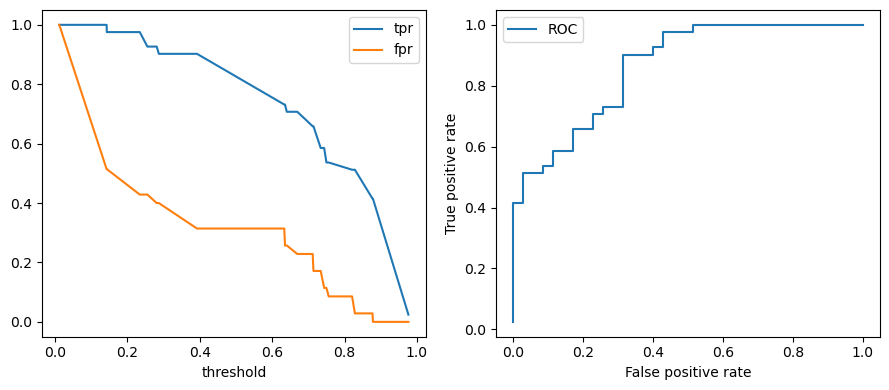

In [79]:
fig, ax = plt.subplots(1,2, figsize = (9,4))
bestmod_thresh_df.plot(x = 'threshold', y = 'tpr', ax = ax[0])
bestmod_thresh_df.plot(x = 'threshold', y = 'fpr', ax = ax[0])
bestmod_thresh_df.plot(x = 'fpr', y = 'tpr', ax = ax[1], label = 'ROC')
ax[1].set_ylabel('True positive rate')
ax[1].set_xlabel('False positive rate')
plt.tight_layout()

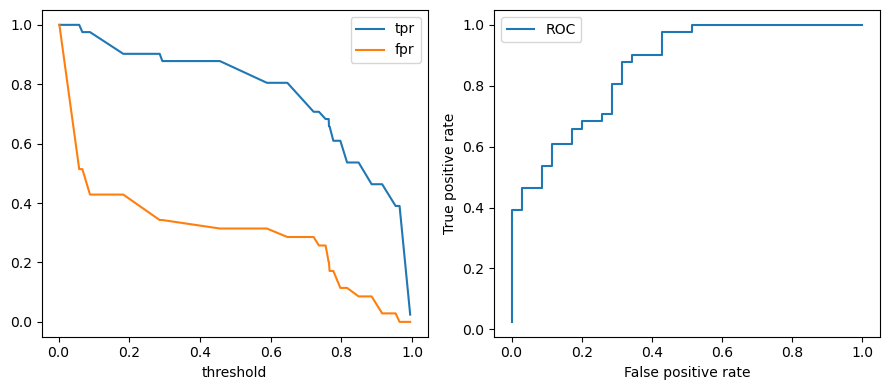

In [80]:
# with default log regression
fig, ax = plt.subplots(1,2, figsize = (9,4))
thresh_df.plot(x = 'threshold', y = 'tpr', ax = ax[0])
thresh_df.plot(x = 'threshold', y = 'fpr', ax = ax[0])
thresh_df.plot(x = 'fpr', y = 'tpr', ax = ax[1], label = 'ROC')
ax[1].set_ylabel('True positive rate')
ax[1].set_xlabel('False positive rate')
plt.tight_layout()

Tuning and optimizing on ROC/AUC makes a difference:
- region where we can decrease threshold (making more sensitive detector)
- no increase in FPR, increasing TPR

Finding the best threshold value operating point:
- using Yuden's J

But ultimately this is up to you. Can assess visually.

In [81]:
best_idx = bestmod_thresh_df['J_stat'].idxmax()
best_point = pd.DataFrame(bestmod_thresh_df.iloc[best_idx]).T
best_point

,threshold,tpr,fpr,J_stat
17,0.286846,0.902439,0.4,0.502439


Using Youden's J-statistic:

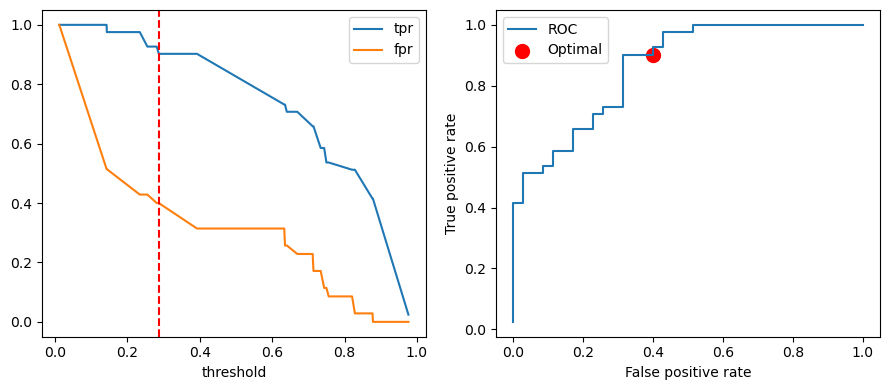

In [82]:
fig, ax = plt.subplots(1,2, figsize = (9,4))
bestmod_thresh_df.plot(x = 'threshold', y = 'tpr', ax = ax[0])
bestmod_thresh_df.plot(x = 'threshold', y = 'fpr', ax = ax[0])
ax[0].axvline(best_point['threshold'].values, c = 'r', linestyle = '--')

bestmod_thresh_df.plot(x = 'fpr', y = 'tpr', ax = ax[1], label = 'ROC')
best_point.plot.scatter(x = 'fpr', y = 'tpr', ax = ax[1], c ='r', s = 100, label = 'Optimal')
ax[1].set_ylabel('True positive rate')
ax[1].set_xlabel('False positive rate')

plt.tight_layout()

Is this optimal? Maybe, maybe not.
- If we care about keeping fpr low, choose threshold = 0.4 instead.

Once satisfied with operating threshold:
- filter probabilities according to threshold

In [83]:
#filter on class 1 probabilities
y_pred_best_with_threshold = (y_pred_probs[:,1] >= 0.4).astype(int)
y_pred_best_with_threshold

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1])

Let's get classification report for this AUC-selected, threshold tuned model:
- Threshold at 0.4

In [84]:
print(classification_report(y_test, y_pred_best_with_threshold))

              precision    recall  f1-score   support

           0       0.83      0.69      0.75        35
           1       0.77      0.88      0.82        41

    accuracy                           0.79        76
   macro avg       0.80      0.78      0.78        76
weighted avg       0.79      0.79      0.79        76



Look at confusion matrix at this threshold:

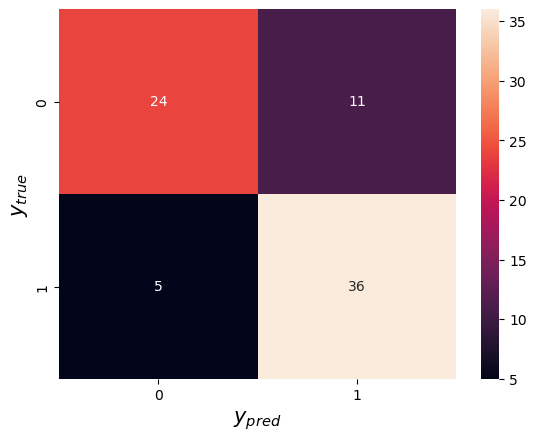

In [85]:
conf_mat_best = confusion_matrix(y_test, y_pred_best_with_threshold)
fig, ax = plt.subplots()
sns.heatmap(conf_mat_best, annot = True, ax = ax)
ax.set_ylabel(r'$y_{true}$', size = 15)
ax.set_xlabel(r'$y_{pred}$', size = 15)
plt.show()

Without any feature engineering, this is a good job.


Instructive to look at original model performance vs. tuned/thresholded model.

In [86]:
print(classification_report(y_test, y_pred_best_with_threshold))

              precision    recall  f1-score   support

           0       0.83      0.69      0.75        35
           1       0.77      0.88      0.82        41

    accuracy                           0.79        76
   macro avg       0.80      0.78      0.78        76
weighted avg       0.79      0.79      0.79        76



In [87]:
y_pred_orig = hd_model.predict(X_test_sc)
print(classification_report(y_test, y_pred_orig))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72        35
           1       0.75      0.80      0.78        41

    accuracy                           0.75        76
   macro avg       0.75      0.75      0.75        76
weighted avg       0.75      0.75      0.75        76



These kinds of considerations:
- ROC/AUC and model discriminatory power
- Tuning thresholds

Can be extended to multi-class problems:
- one verse rest (OvR)
- one verse one (OvO)

Custom code needs to be built and time consuming